In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy.stats import chi2_contingency

plt.style.use('fivethirtyeight')

In [2]:
# Loading and cleaning the dataset
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
df = df[pd.notnull(df['Critic_Score'])]

#
# There are only very small samples of data before the year 2000, so we only choose data after 2000.
#
df = df[df['Year_of_Release'] >= 2000.0]

# Utilities functions:
def CI_mean(data):
    se = np.std(data)/np.sqrt(len(data))
    low = np.mean(data)-1.96*se
    up = np.mean(data)+1.96*se
    return low,up
    
def CI_mean_diff(list1, list2):
    s1 = np.var(list1)
    s2 = np.var(list2)
    n1 = len(list1)
    n2 = len(list2)
    se2 = s1/n1 + s2/n2
    se = np.sqrt(se2)

    diff = np.mean(list1) - np.mean(list2)
    low = diff - 1.96 * se
    up = diff + 1.96 * se
    return low, up

len(df)

7887

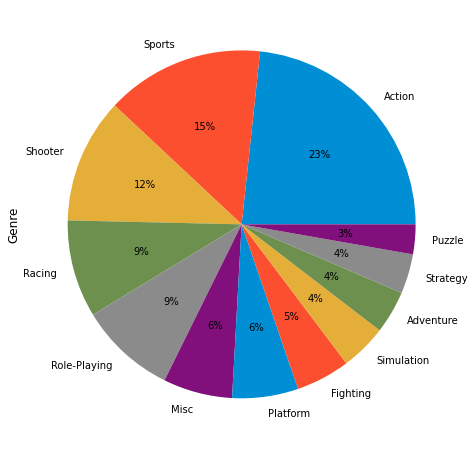

In [3]:
# Games by Genre in the dataset
counts = df['Genre'].value_counts()
counts.plot.pie(labels=counts.index, autopct='%1.0f%%', figsize=(15,8))

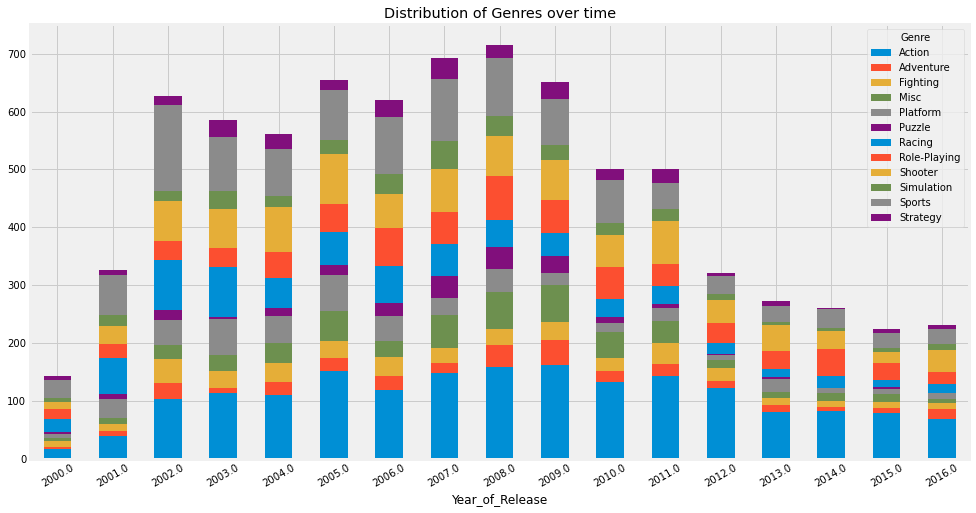

In [4]:
# Genre distribution over time
pivot = df.groupby(['Year_of_Release', 'Genre']).size().unstack(fill_value=0)
pivot.plot(kind='bar', stacked=True, figsize=(15,8), title='Distribution of Genres over time')
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=30)

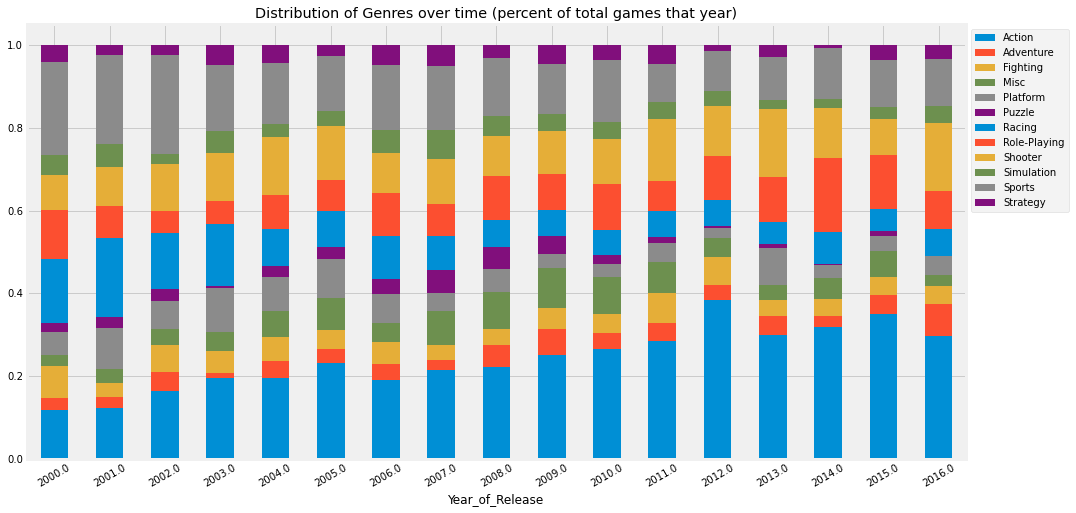

In [5]:
# Genre distribution over time (Percentage of total)
pivot = df.groupby(['Year_of_Release', 'Genre']).size().unstack()
pivot_pct = (pivot.T / pivot.T.sum()).T
pivot_pct.plot(kind='bar', stacked=True, figsize=(15,8), title='Distribution of Genres over time (percent of total games that year)')
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=30)
plt.legend(bbox_to_anchor=(1, 1))

In [6]:
# 
# Is there a relationship between Year and Genre?
# Chi-Square of independence between years (2005-2010, 2010-2015) and Genres (Action, Adventure, Fighting..)
#
def which_gen(year):   
    if year >= 2005 and year < 2010:
        return 'Old_Gen'
    elif year >= 2010 and year <= 2015:
        return 'New_Gen'
    else:
        return 'none'
    

after_2005 = df[df['Year_of_Release'] >= 2005]
after_2005['gen'] = after_2005['Year_of_Release'].apply(which_gen)
after_2005 = after_2005[after_2005['gen'] != 'none']
tab = pd.crosstab(after_2005['gen'], after_2005['Genre'])
tab
print(tab)
print('----------')
result = sm.stats.Table(tab).test_nominal_association()
print(result)

Genre    Action  Adventure  Fighting  Misc  Platform  Puzzle  Racing  \
gen                                                                    
New_Gen     643         81       113   134        86      27     127   
Old_Gen     742        142       148   265       196     144     264   

Genre    Role-Playing  Shooter  Simulation  Sports  Strategy  
gen                                                           
New_Gen           233      265          69     238        64  
Old_Gen           302      355         170     470       135  
----------
df          11
pvalue      0.0
statistic   125.08737141550657


C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [7]:
#
#
# INTENTIONALLY LEFT BLANK
#
#

Text(0.5, 0, 'Revenue (in $MM)')

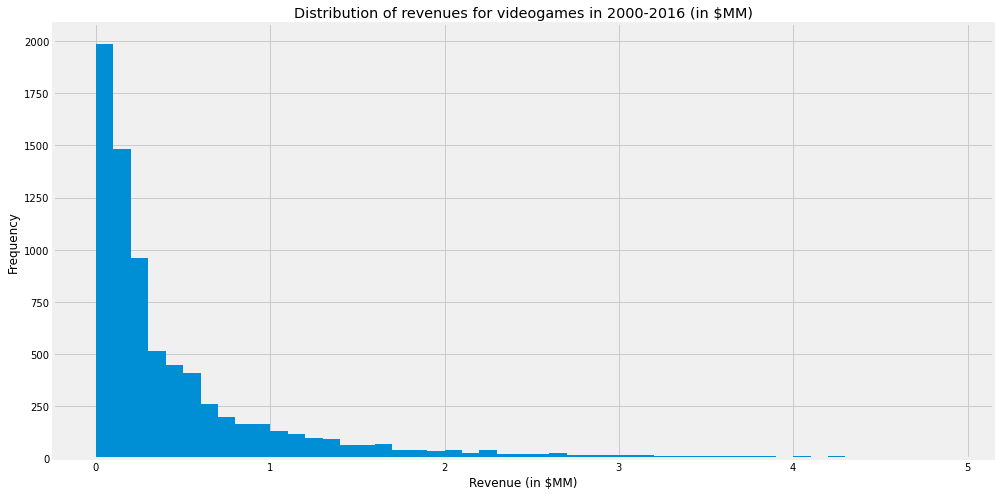

In [8]:
# Explore distribution of revenue numbers
df['Global_Sales'].plot(kind='hist', bins=np.arange(0.0, 5.0, 0.1), figsize=(15,8), title='Distribution of revenues for videogames in 2000-2016 (in $MM)')
plt.xlabel('Revenue (in $MM)')

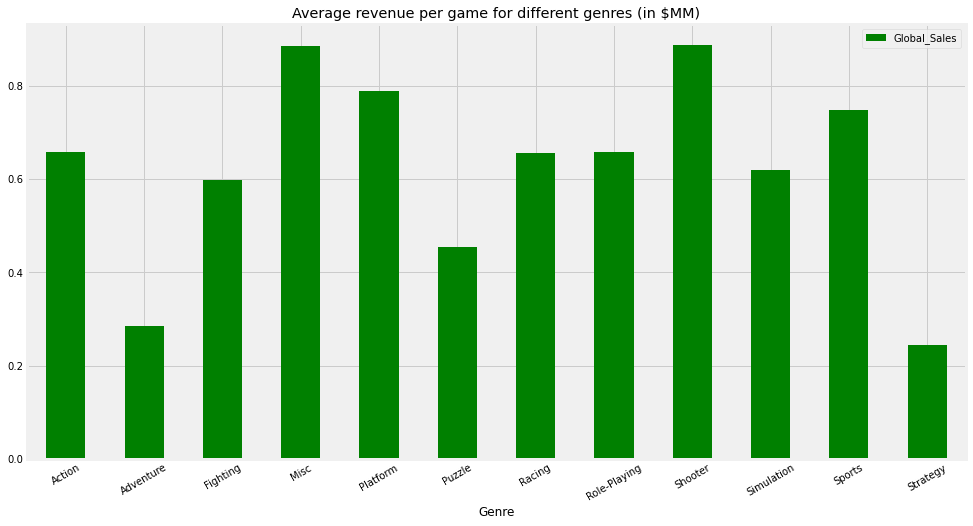

In [9]:
#
# Explore sales data per genre
# #
# Dollars per game per genre
df[['Genre', 'Global_Sales']].groupby('Genre').mean().plot(
    kind='bar', 
    title='Average revenue per game for different genres (in $MM)', 
    figsize=(15,8),
    color='green')
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=30)

Text(0, 0.5, 'Revenue (in $MM)')

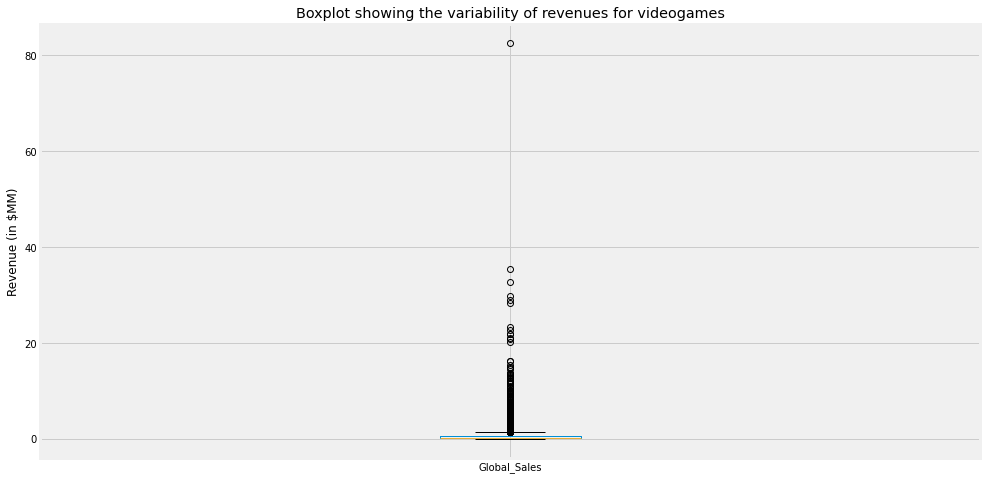

In [10]:
#
# Explore sales data per genre
#
# df.groupby('Genre').mean()
df['Global_Sales'].plot(kind='box', figsize=(15,8), title='Boxplot showing the variability of revenues for videogames')
plt.ylabel('Revenue (in $MM)')

In [11]:
#
# INTENTIONALLY LEFT BLANK
#

In [12]:
#
# Test mean difference of global sales for Sports games vs Shooter games
#
genre1 = df[df['Genre'] == 'Shooter']
genre2 = df[df['Genre'] == 'Sports']


print ("Means with 95% CI: ")
print('Shooter:', genre1['Global_Sales'].mean(), CI_mean(genre1['Global_Sales']))
print('Sports:', genre2['Global_Sales'].mean(), CI_mean(genre2['Global_Sales']))
print('')

res = stats.ttest_ind(genre1['Global_Sales'], genre2['Global_Sales'], equal_var = False)
print(res)

diff = CI_mean_diff(genre1['Global_Sales'], genre2['Global_Sales'])
print('mean. diff 95% CI:', diff)

# Result: CANNOT REJECT THE NULL!

Means with 95% CI: 
Shooter: 0.8886681222707399 (0.771636656080834, 1.0056995884606459)
Sports: 0.7491472868217035 (0.5841437889741363, 0.9141507846692707)

Ttest_indResult(statistic=1.3511702901080893, pvalue=0.17679493012749292)
mean. diff 95% CI: (-0.06277231416431855, 0.3418139850623913)


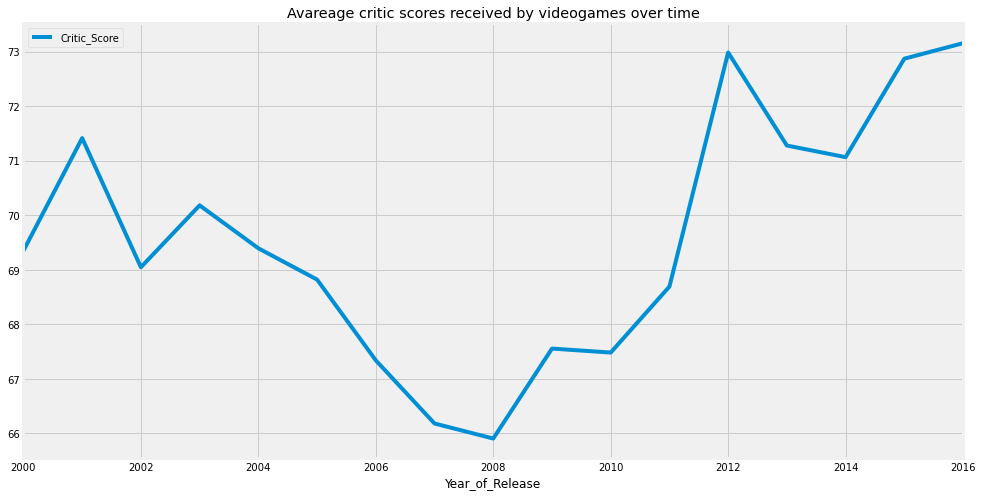

In [13]:
#
# Average Critic scores over time for all videogames released that year
#
df[['Year_of_Release', 'Critic_Score']].groupby('Year_of_Release').mean().plot(figsize=(15,8), title='Avareage critic scores received by videogames over time')

In [14]:
#
# Are avg. critic score for Action higher than Sprots?
#
period_new = df[df['Year_of_Release'] >= 2010]
period_old = df[df['Year_of_Release'] < 2010]


print ("Means with 95% CI: ")
print('Old:', period_old['Critic_Score'].mean(), CI_mean(period_old['Critic_Score']))
print('New:', period_new['Critic_Score'].mean(), CI_mean(period_new['Critic_Score']))
print('')

res = stats.ttest_ind(period_old['Critic_Score'], period_new['Critic_Score'], equal_var = False)
print(res)

diff = CI_mean_diff(period_new['Critic_Score'], period_old['Critic_Score'])
print('mean. diff 95% CI:', diff)

# Result: CAN REJECT! --


Means with 95% CI: 
Old: 68.19730941704036 (67.83133840104743, 68.56328043303328)
New: 70.45415224913495 (69.90146605449038, 71.00683844377951)

Ttest_indResult(statistic=-6.671934171859186, pvalue=2.835263995255254e-11)
mean. diff 95% CI: (1.5939726982843616, 2.9197129659048207)


In [15]:
#
# INTENTIONALLY LEFT BLANK
#

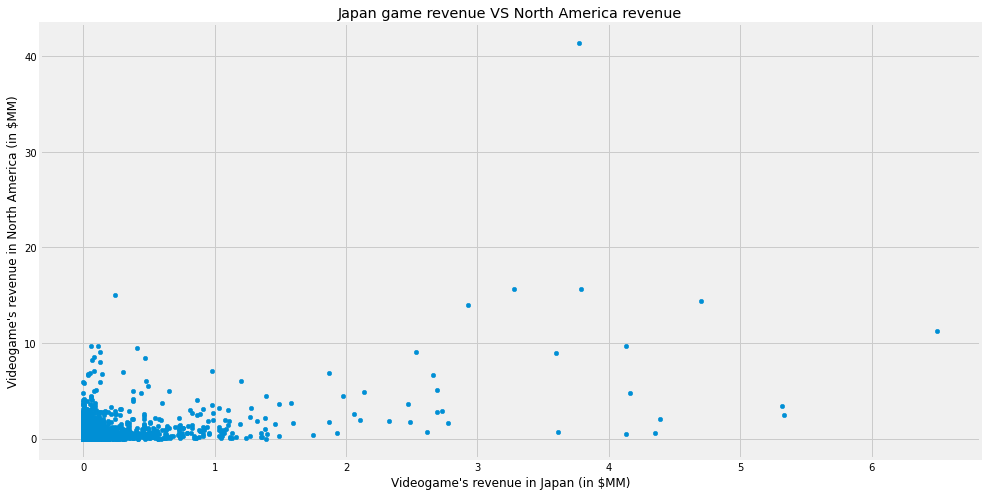

In [16]:
df.plot(kind='scatter', x='JP_Sales', y='NA_Sales', figsize=(15,8), title='Japan game revenue VS North America revenue')
plt.xlabel("Videogame's revenue in Japan (in $MM)")
_ = plt.ylabel("Videogame's revenue in North America (in $MM)")

In [17]:
# Linear Regression -- try to predict North America sales given Japan Sales of a game
X = np.array(df['JP_Sales'])
y = np.array(df['NA_Sales'])
X = sm.add_constant(X)
res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     2251.
Date:                Wed, 23 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:01:54   Log-Likelihood:                -9359.5
No. Observations:                7887   AIC:                         1.872e+04
Df Residuals:                    7885   BIC:                         1.874e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2635      0.009     28.925      0.000       0.246       0.281
x1             1.6544      0.035     47.449      0.000       1.586       1.723
==============================================================================
Omnibus:                    15112.117   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         87795829.652
Skew:                          14.361   Prob(JB):                         0.00
Kurtosis:                     519.078   Cond. No.                         3.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

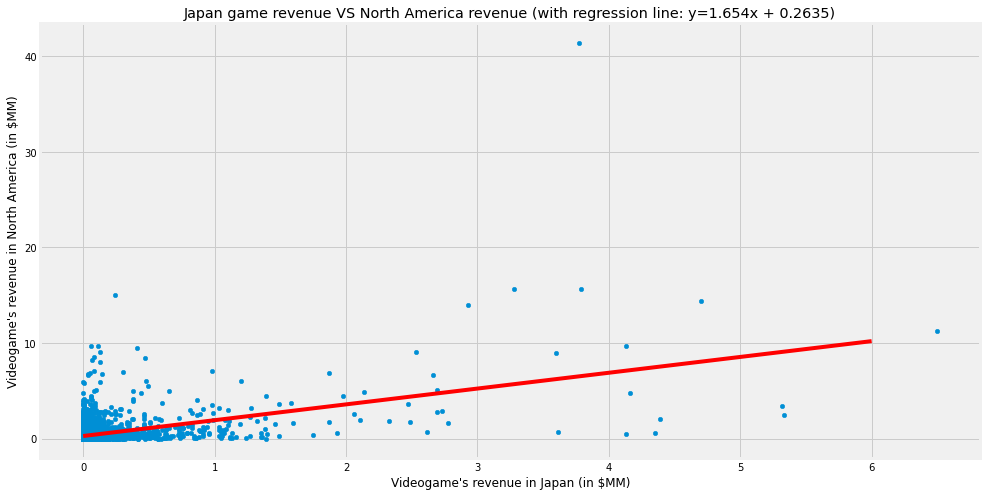

In [18]:
df.plot(kind='scatter', x='JP_Sales', y='NA_Sales', figsize=(15,8), title='Japan game revenue VS North America revenue (with regression line: y=1.654x + 0.2635)')
plt.xlabel("Videogame's revenue in Japan (in $MM)")
_ = plt.ylabel("Videogame's revenue in North America (in $MM)")

X_plot = np.linspace(0,6,10)
plt.plot(X_plot, X_plot*res.params[1] + res.params[0], color='red')
plt.show()

In [19]:
#
# INTENTIONALLY LEFT BLANK
#

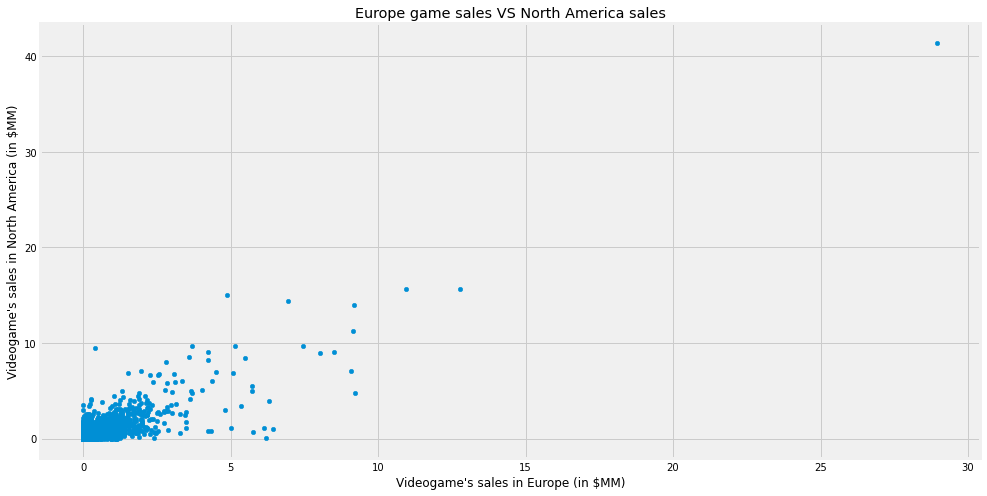

In [20]:
df.plot(kind='scatter', x='EU_Sales', y='NA_Sales', figsize=(15,8), title='Europe game sales VS North America sales')
plt.xlabel("Videogame's sales in Europe (in $MM)")
_ = plt.ylabel("Videogame's sales in North America (in $MM)")

In [21]:
# Linear Regression -- try to predict North America sales given Japan Sales of a game
X = np.array(df['EU_Sales'])
y = np.array(df['NA_Sales'])
X = sm.add_constant(X)
res2 = sm.OLS(y, X).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                 1.922e+04
Date:                Wed, 23 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:01:55   Log-Likelihood:                -5480.9
No. Observations:                7887   AIC:                         1.097e+04
Df Residuals:                    7885   BIC:                         1.098e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1048      0.006     18.264      0.000       0.094       0.116
x1             1.1875      0.009    138.632      0.000       1.171       1.204
==============================================================================
Omnibus:                     4994.636   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1989566.468
Skew:                           1.798   Prob(JB):                         0.00
Kurtosis:                      80.726   Cond. No.                         1.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

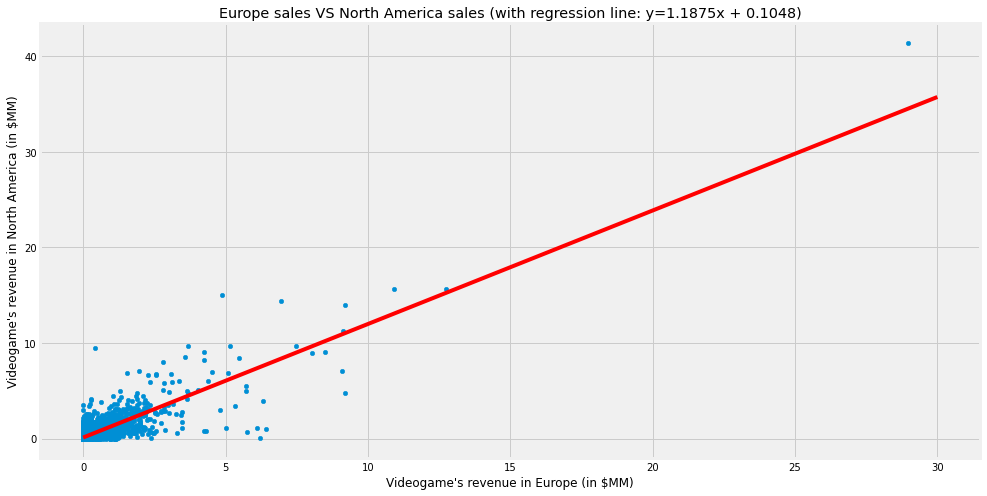

In [22]:
df.plot(kind='scatter', x='EU_Sales', y='NA_Sales', figsize=(15,8), title='Europe sales VS North America sales (with regression line: y=1.1875x + 0.1048)')
plt.xlabel("Videogame's revenue in Europe (in $MM)")
_ = plt.ylabel("Videogame's revenue in North America (in $MM)")

X_plot = np.linspace(0,30,10)
plt.plot(X_plot, X_plot*res2.params[1] + res2.params[0], color='red')
plt.show()